In [1]:
import os

from matplotlib import pyplot as plt     # For plotting the images
import numpy as np                       # To store data
import tensorflow as tf                  # To create, train, predict model

from tensorflow.keras.datasets import mnist 
                                         # To load images for train, test
from tensorflow.random import normal     # To induce random noise to images
from tensorflow.keras.layers import (    # To add layers in encoder and decoder 
            Conv2D,
            MaxPool2D,
            Conv2DTranspose)
from tensorflow.keras.callbacks import ModelCheckpoint 
                                          # To save checkpoints during training

In [2]:
def greyScaleTransform(img,range=255,minGrey=None,maxGrey=None):
  '''
  This function transforms an input image to a grey scale range of [0,range]
  Input: img     -> a tensor or a matrix
         range   -> required grey scale range to be converted to
                    default is [0,255]
         minGrey -> minimum grey value of img (input)
                    If not provided, the function calculates it from img
         maxGrey -> maximum grey value of img (input)
                    If not provided, the function calculates it from img
         To transform multiple tensors to a common scale of grey values, this
         function can be called for transforming each tensors, with fixed
         minGrey, maxGrey values.
  Output: A tensor with same dimensions as img, with its grey values linearly
          transformed to fit range. 
  '''
  if minGrey is None:
    minGrey=np.min(img)
  if maxGrey is None:
    maxGrey=np.max(img)
  return ((img-minGrey)/(maxGrey-minGrey))*range

(60000, 28, 28)
(10000, 28, 28)


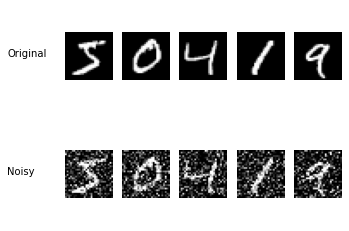

In [22]:
## Load data
(x_train,_),(x_test,_)=mnist.load_data()
print(x_train.shape)
print(x_test.shape)

## Add random noise to train data
stdev=100
x_train_noisy = x_train + normal(stddev=stdev,shape=x_train.shape)
x_train_noisy = np.clip(x_train_noisy,0,255)

x_train=x_train.astype('float32')/255
x_train_noisy=x_train_noisy.astype('float32')/255

## Plot original and noisy images
plt.clf()                        # Clear figure
n=6                              # Plot first 5 images
plt.subplot(2,n,1)
plt.text(0.0,0.5,"Original")
plt.axis('off')

plt.subplot(2,n,n+1)
plt.text(0.0,0.5,"Noisy")
plt.axis('off')

for i in range(n-1):
  plt.subplot(2,n,i+2)
  plt.imshow(x_train[i],cmap='gray') 
  plt.axis('off')

  plt.subplot(2,n,n+i+2)
  plt.imshow(x_train_noisy[i],cmap='gray')
  plt.axis('off')

plt.show() 

In [16]:
## Build autoencoder

# encoder
dae=tf.keras.Sequential()                        # Build a sequential model
dae.add(tf.keras.Input(shape=(28,28,1)))         # Specify expected input size
dae.add(Conv2D(16,5,activation='selu'))          # 16 conv2D (5 x 5 x 1) filters
dae.add(MaxPool2D(pool_size=2,padding='valid'))  # MaxPool to half size
dae.add(Conv2D(32,5,activation='selu'))          # 32 conv2D (5 x 5 x 16) filters
dae.add(MaxPool2D(pool_size=2,padding='valid'))  # MaxPool to half size

# decoder
dae.add(Conv2DTranspose(
    32,3,2,padding='same',activation='selu'))    # inverse of 32 Conv2D (3 x 3 x 32) filters, strides = 2 
dae.add(Conv2DTranspose(
    16,7,activation='selu'))                     # inverse of 32 Conv2D with (7 x 7 x 16) filters
dae.add(Conv2DTranspose(
    1,3,2,padding='same',activation='sigmoid'))  # inverse of 16 Conv2D (3 x 3 x 1) filters, strides = 2 

## Compile autoencoder
dae.compile(loss='bce',optimizer='Adam')         # binary cross entropy loss function and Adam optimizer 
dae.summary()                                    # display summary of the model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 24, 24, 16)        416       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 32)          12832     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 8, 8, 32)         9248      
 ranspose)                                                       
                                                      

In [17]:
## Train autoencoder
epoch=30                                 # Number of epochs to be trained on
bsize=200                                # Batch size within an epoch

cp_filepath = './checkpoint'             # Path for storing checkpoint

cp_callbak=ModelCheckpoint(              # Defining checkpoint type
    filepath=cp_filepath,
    save_weights_only=True,              # Only weights be saved, not whole model 
    monitor='loss',                      # Decide best based on loss
    mode='min',                          # minimum loss is the best
    save_best_only=True)                 # save checkpoint only if the model is the best

dae.fit(x=x_train_noisy,y=x_train,epochs=epoch,batch_size=bsize,
        callbacks=[cp_callbak])          # train with input as noisy and label as original
dae.load_weights(cp_filepath)            # load the best weights saved by checkpoint

Epoch 1/30
300/300 [==============================] - 60s 197ms/step - loss: 0.1948
Epoch 2/30
300/300 [==============================] - 59s 198ms/step - loss: 0.1126
Epoch 3/30
300/300 [==============================] - 58s 195ms/step - loss: 0.1038
Epoch 4/30
300/300 [==============================] - 58s 195ms/step - loss: 0.1000
Epoch 5/30
300/300 [==============================] - 58s 195ms/step - loss: 0.0976
Epoch 6/30
300/300 [==============================] - 59s 195ms/step - loss: 0.0961
Epoch 7/30
300/300 [==============================] - 59s 198ms/step - loss: 0.0951
Epoch 8/30
300/300 [==============================] - 58s 195ms/step - loss: 0.0941
Epoch 9/30
300/300 [==============================] - 59s 196ms/step - loss: 0.0934
Epoch 10/30
300/300 [==============================] - 59s 196ms/step - loss: 0.0927
Epoch 11/30
300/300 [==============================] - 59s 197ms/step - loss: 0.0921
Epoch 12/30
300/300 [==============================] - 59s 196ms/step - lo

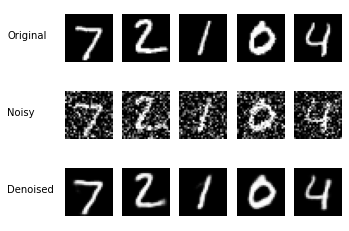

In [23]:
## Evaluate the Denoising Autoencoder

dae.load_weights(cp_filepath)            # load the best weights saved by checkpoint

# Add random noise to test data
stdev=100
x_test_noisy = x_test + normal(stddev=stdev,shape=x_test.shape)
x_test_noisy = np.clip(x_test_noisy,0,255)

x_test=x_test.astype('float32')/255
x_test_noisy=x_test_noisy.astype('float32')/255

# Denoise test data
pred=dae.predict(x_test_noisy)
pred=pred.reshape(pred.shape[:-1])

# Plot denoised images
plt.clf()

plt.subplot(3,n,1)
plt.text(0,0.5,"Original")
plt.axis('off')

plt.subplot(3,n,n+1)
plt.text(0,0.5,"Noisy")
plt.axis('off')

plt.subplot(3,n,2*n+1)
plt.text(0,0.5,"Denoised")
plt.axis('off')

for i in range(n-1):

  plt.subplot(3,n,i+2)
  plt.imshow(x_test[i],cmap='gray') 
  plt.axis('off')

  plt.subplot(3,n,n+i+2)
  plt.imshow(x_test_noisy[i],cmap='gray')
  plt.axis('off')

  plt.subplot(3,n,2*n+i+2)
  plt.imshow(pred[i],cmap='gray')
  plt.axis('off')

plt.show()

In [24]:
## Calculate mean and principal components of the residual errors

from cv2 import PCACompute as pca   # for PCA analysis

# Calculate residual erros
resErr = x_test - pred              # Residual error = original - denoised images

# PCA analysis to obtain mean and 5 principal components of residual erros
x=resErr.reshape(resErr.shape[0],resErr.shape[1]*resErr.shape[2]) 
                                    # Flatten each image to vectors
numPC=5                             # Number of principal components to calculate 
          
mean, eigenVectors = pca(x, mean=None, maxComponents=numPC)
                                    # Conduct PCA analysis : get mean, and eigenvectors corresponding to largest 5 eigenvalues
mean=mean.reshape(resErr.shape[1],resErr.shape[2])
                                    # Convert the mean to a 2D image
eigenVectors = eigenVectors.reshape(numPC,resErr.shape[1],resErr.shape[2])
                                    # Convert the principal components to 2D images

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

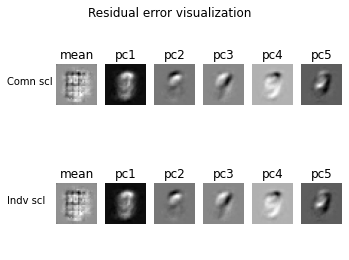

In [25]:
from google.colab import files                      # To import image plots to local disc

## Display the mean and the five principal components

# Prepare the images in a common scale of range [0,255] 
minGrey=np.min([np.min(eigenVectors),np.min(mean)]) # Calculate minimum element-> to be converted to grey scale 0
maxGrey=np.max([np.max(eigenVectors),np.max(mean)]) # Calculate maximum element-> to be converted to grey scale 255
minMaxRange=maxGrey-minGrey                         # Calculate range = max - min -> to be converted to range [0,255]

meanC=greyScaleTransform(mean,255,minGrey,maxGrey)  # Linear grey scale transform from [minGrey,maxGrey] to [0,255] on common scale
eigenVectorsC=greyScaleTransform(eigenVectors,255,minGrey,maxGrey)

# Convert the images to range [0,255] individually
# This conversion is not required as matplotlib will automatically scale the intensitiy values
# while plotting individual images. Still incorporated this as it is mentioned in the assignment.

meanI=greyScaleTransform(mean).astype(np.uint8)
eigenVectorsI=np.zeros(eigenVectors.shape,dtype=np.uint8)
for i in range(numPC):
  eigenVectorsI[i]=greyScaleTransform(eigenVectors[i])

# Plot the resudual error mean and five principal components
plt.clf()

plt.suptitle("Residual error visualization")
plt.subplot(2,numPC+2,1)
plt.text(0,0.5,"Comn scl")
plt.axis('off')

plt.subplot(2,numPC+2,numPC+3)
plt.text(0,0.5,"Indv scl")
plt.axis('off')

plt.subplot(2,numPC+2,2)
plt.imshow(meanC,cmap='gray') 
plt.axis('off')
plt.title("mean")

plt.subplot(2,numPC+2,numPC+4)
plt.imshow(meanI,cmap='gray') 
plt.axis('off')
plt.title("mean")

for i in range(numPC):
  plt.subplot(2,numPC+2,i+3)
  plt.imshow(eigenVectorsC[i],cmap='gray') 
  plt.axis('off')
  plt.title('pc'+str(i+1))

  plt.subplot(2,numPC+2,numPC+5+i)
  plt.imshow(eigenVectorsI[i],cmap='gray') 
  plt.axis('off')
  plt.title('pc'+str(i+1))

plt.savefig("DAE_MNIST_ResErr.jpg")
files.download("DAE_MNIST_ResErr.jpg")

plt.show()